## Метрика оценивания соревнования на Kaggle

Метрикой оценки является процент верно классифицированных пассажиров, т.е. точность(accuracy).

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [2]:
sns.set(rc={'figure.figsize' : (7, 5)})
sns.color_palette("pastel")
sns.set_style("ticks") 

## Функция для вывода метрик оценки модели

In [3]:
def metrics_summary(y_pred, y_pred_proba, model):
    print('\033[4mAccuracy\033[0m: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('ROC-AUC: ', roc_auc_score(y_test, y_pred_proba))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, labels=model.classes_),
                                  display_labels=model.classes_)
    disp.plot()
    plt.show()

## Функция для подбора параметров модели

In [4]:
def find_best_parameters(X_train, y_train, model):

    parameters = {'n_estimators' : range(5, 150, 5),
                  'max_depth': range(3, 13, 2),
                  'min_samples_split' : range(10, 20, 2),
                  'min_samples_leaf' : range(10, 20, 2)}

    kf = StratifiedKFold(n_splits=10,
                         shuffle=True,
                         random_state=42)

    grid_search_cv = GridSearchCV(estimator=model,
                                  param_grid=parameters,
                                  cv=kf,
                                  scoring='roc_auc',
                                  n_jobs=-1,
                                  verbose=0)

    grid_search_cv.fit(X_train, y_train)
    
    return grid_search_cv.best_estimator_, grid_search_cv.best_params_

## Загрузка данных

In [5]:
train_df = pd.read_csv('data/preprocessed_data/preprocessed_train.csv')
test_df = pd.read_csv('data/preprocessed_data/preprocessed_test.csv')
submission = pd.read_csv('data/preprocessed_data/submission.csv')

Удаляю признаки _SibSp_ и _Parch_ по скольку при наличии нового признака _Relatives_ они не будут нести для модели никакой новой информации.

In [6]:
for df in [train_df, test_df]:
    df.drop(['SibSp'], axis=1, inplace=True)
    df.drop(['Parch'], axis=1, inplace=True)

## Итоговый вид датафреймов

In [7]:
train_df.head()

,Survived,Age,Fare,Relatives,IsAlone,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,22.0,7.2500,1,0.0,True,False,True,False,True
1,1,38.0,71.2833,1,0.0,False,False,False,False,False
2,1,26.0,7.9250,0,1.0,False,False,True,False,True
3,1,35.0,53.1000,1,0.0,False,False,True,False,False
4,0,35.0,8.0500,0,1.0,True,False,True,False,True


In [8]:
test_df.head()

,Age,Fare,Relatives,IsAlone,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,34.5,7.8292,0,1.0,True,True,False,False,True
1,47.0,7.0000,1,0.0,False,False,True,False,True
2,62.0,9.6875,0,1.0,True,True,False,True,False
3,27.0,8.6625,0,1.0,True,False,True,False,True
4,22.0,12.2875,2,0.0,False,False,True,False,True


## Разделение данных на тренировочную и тестовую выборки

In [9]:
X = train_df.drop(['Survived'], axis = 1)
y = train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print("Размер тренировочной выборки: ", X_train.shape[0])
print("Размер тестовой выборки: ", X_test.shape[0])

Размер тренировочной выборки:  712
Размер тестовой выборки:  179


## Модель Random Forest

### Подбор параметров с помощью кросс-валидации

In [11]:
rf_clf = RandomForestClassifier()
start_time = time.time()
best_rf_clf, best_rf_params = find_best_parameters(X_train, y_train, rf_clf)
end_time = time.time()

In [12]:
print(f'Лучшие параметры: {best_rf_params}')
print(f'Общее время, затраченное на кросс-валидацию (в минутах): {(end_time - start_time)/60}')

Лучшие параметры: {'max_depth': 11, 'min_samples_leaf': 10, 'min_samples_split': 18, 'n_estimators': 5}
Общее время, затраченное на кросс-валидацию (в минутах): 18.041418743133544


### Оценка важности признаков

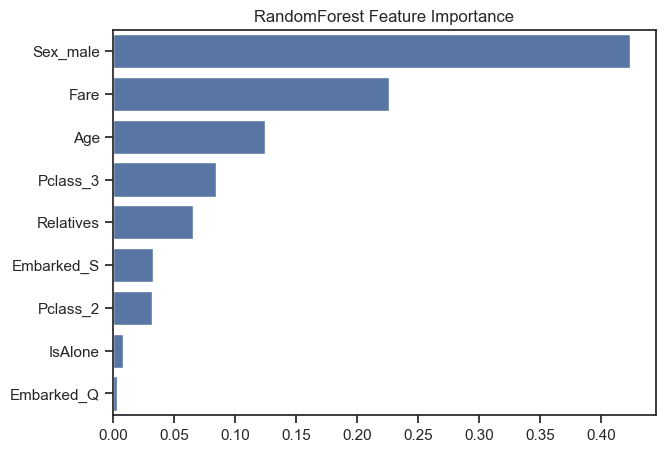

In [13]:
importances = best_rf_clf.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
sns.barplot(feature_importances, orient="h")
plt.title("RandomForest Feature Importance")
plt.show()

### Тестирование модели и результаты по основным метрикам

Accuracy:  0.8100558659217877
Precision:  0.8448275862068966
Recall:  0.6621621621621622
F1:  0.7424242424242424
ROC-AUC:  0.8857142857142857


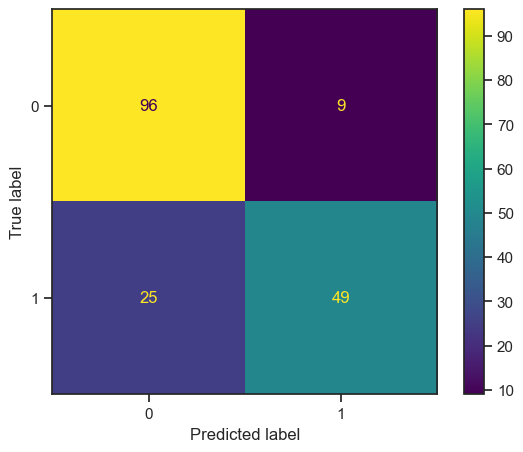

In [14]:
y_pred = best_rf_clf.predict(X_test)
y_pred_proba = best_rf_clf.predict_proba(X_test)[:, 1]
metrics_summary(y_pred, y_pred_proba, best_rf_clf)

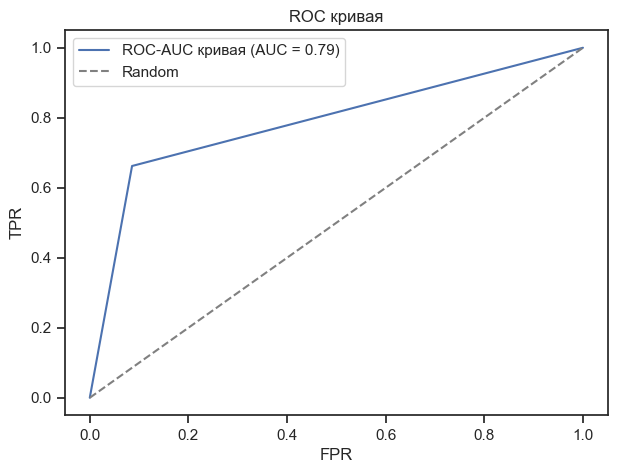

In [15]:
sns.set_style("ticks")
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f'ROC-AUC кривая (AUC = {roc_auc_score(y_test, y_pred):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC кривая')
plt.legend()
plt.style.use('ggplot')
plt.show()

### Kaggle Score

In [16]:
submission['Survived'] = best_rf_clf.predict(test_df)
submission.to_csv("data/submissions/rf_submission.csv", index=False)

![rf_submission](data/img/rf_submission.png)

## Результаты

- Были использованы, 2 искусствено сгенерированных признака: IsAlone и Relatives;
- Для корректной обработки категориальных признаков были применен OneHotEncoding;
- Была построенна модель Случайного леса;
- Для поиска лучших параметров модели использовался метод GridSearchCV библиотеки scikit-learn;
- Длительность кросс-валидации составила примерное 18 минут. 

## Итоговые показатели метрики Accuracy модели на тестовой выборке

- **_Random Forest_** - 0.78229